In [1]:
cd ..

c:\Users\seand\OneDrive\Dokumente\Masterthesis\StarBoundaryNetworks\src


In [2]:
import torch
from torch.autograd.functional import hessian
from torch import nn
from tqdm import tqdm

from domains.starDomain import Sphere
from radialFunctions.radialFunctions import linearRadial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy.interpolate import griddata
from ipywidgets import *
import numpy as np
#%matplotlib notebook
%matplotlib widget

# Define Problem

$u_xx(x,y) + u_yy(x,y) = sin(xy)$ on unit sphere

and boundary condition $u(x,y) = x+y$ on sphere

## Define Loss funciton

In [3]:
def laplacian(f, input):
    dim = input.shape[1]
    batchSize = input.shape[0]
    outf = f(input)
    laplacian = torch.zeros(batchSize, dtype=float, requires_grad=True)


    

    dx = torch.autograd.grad(outf, input, torch.ones((batchSize, 1), requires_grad=True), create_graph=True)[0]

    for i in range(dim):
        d2x = torch.autograd.grad((dx[:,i]).view(-1,1), input, torch.ones((batchSize, 1), requires_grad=True), create_graph=True)[0][:,i]
        laplacian = laplacian + d2x



    return laplacian.view(-1,1)
    


In [4]:
#define PINN loss function for problem from above:
def pinnLossPoissonSin(u, xy_grid):#, device = 'cuda'):

  laplacian_u = laplacian(u, xy_grid)
  #ignore non differentiable points
  maskWhereNotNan = laplacian_u.view(-1).isnan() == False
  laplacian_u_cleaned = laplacian_u[maskWhereNotNan]

  return torch.mean( torch.abs(laplacian_u_cleaned - torch.sin(xy_grid[maskWhereNotNan,0] * xy_grid[maskWhereNotNan, 1]).view(-1,1)  )  ), laplacian_u


In [5]:
#Example on how to use laplacian
grid = torch.arange(10, dtype=float, requires_grad=True).view(-1,2)
def f(grid):
    x1 = grid[:, 0]
    x2 = grid[:, 1]
    return (x1*x1*x2*x2).view(-1,1)

laplacian(f, grid)

tensor([[  2.],
        [ 26.],
        [ 82.],
        [170.],
        [290.]], dtype=torch.float64, grad_fn=<ViewBackward0>)

# Define Neural Network with imposed BC

In [6]:
class ImposedBCPINNSphere2D(nn.Module):
  def __init__(self, n_hidden, n_layers):
    super().__init__()
    self.activation_func = nn.Tanh
    self.in_layer = nn.Sequential(*[nn.Linear(2,n_hidden) , self.activation_func()])
    self.hid_layers = nn.Sequential(*[
        nn.Sequential(*[
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh()
            ])
        for i in range(n_layers)], nn.Linear(n_hidden, n_hidden))
    self.out_layer = nn.Linear(n_hidden,1)
    self.domain = Sphere(2, torch.tensor((0.,0.)), torch.tensor(1.))
    self.radialDecayFunciton = linearRadial
  

  def boundaryCondition(self, input):
    return input[:,0] *input[:,1]
  
  def boundaryConditionSpherical(self, angles):

    return self.boundaryCondition(self.domain.getCartesianCoordinates( self.domain.radiusDomainFunciton(angles) ,angles))
  
  def zeroOnBoundaryExtension(self, input):
    radius, angles = self.domain.getSphericalCoordinates(input)
    
    return self.radialDecayFunciton( radius / self.domain.radiusDomainFunciton(angles)).view(-1,1)
  
  def DCBoundaryExtension(self, input):
    radius, angles = self.domain.getSphericalCoordinates(input)

    return (self.boundaryConditionSpherical( angles) *  (1- self.radialDecayFunciton( radius / self.domain.radiusDomainFunciton(angles)))).view(-1,1)
  
  def forward(self, input):
    x = input + 0
   
    x = self.in_layer(x)
   
    x = self.hid_layers(x)
   
    x = self.out_layer(x)
   

    return x*self.zeroOnBoundaryExtension(input) + self.DCBoundaryExtension(input)

# Train NN

In [7]:
#generate Points for training
sphereForPoints  = Sphere(2,torch.tensor([0.0,0.0]), torch.tensor(1.))
spherePoints = sphereForPoints.generateCartesianRandomPointsFullDomain(100000)


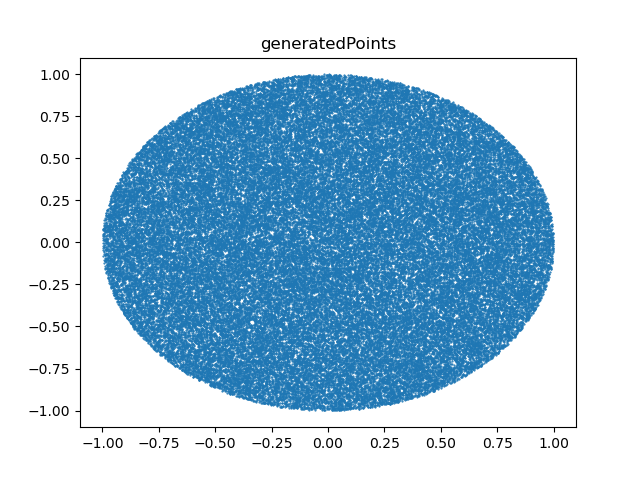

In [8]:
#plot generated points
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.set_title('generatedPoints')
ax1.scatter(spherePoints[:,0],spherePoints[:,1],s = 0.3)
plt.show()

In [17]:
#define Trainingset, epochs, lr:
xy_grid = spherePoints
xy_grid.requires_grad = True
epochs = 300
learningRate  = 1e-3

In [10]:
#define model:
solPDE = ImposedBCPINNSphere2D( 30, 15)

In [18]:
#define optimizer
optimizer = torch.optim.Adam(solPDE.parameters(), lr = learningRate)

In [12]:
#computes initial loss to see where we start
loss, points = pinnLossPoissonSin(solPDE, xy_grid )
loss

tensor(2.3073, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [13]:
# points is the laplacians that were computed in the loss function to see where singularities are
takePoints = torch.argwhere( points.isnan() == 0)
dontTakePoints = torch.argwhere( points.isnan())

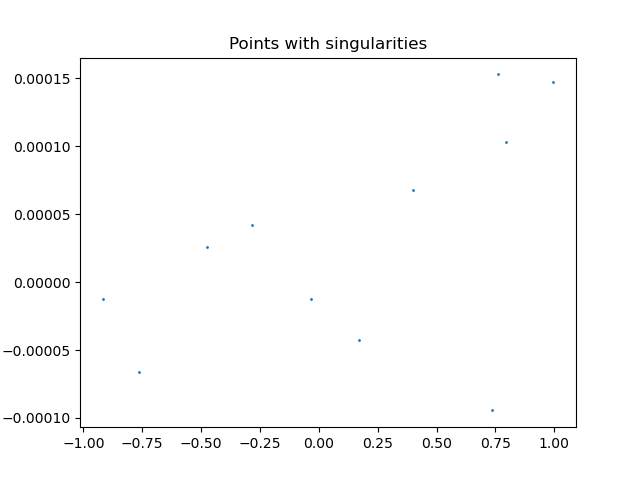

In [14]:
#plot singularities before training
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
ax2.set_title('Points with singularities')
ax2.scatter(spherePoints[dontTakePoints[:,0]][:,0].detach().numpy(),spherePoints[dontTakePoints[:,0]][:,1].detach().numpy(),s = 1)
plt.show()

In [ ]:
#training
for i in range(epochs):
  optimizer.zero_grad()
 
  loss,_ = pinnLossPoissonSin(solPDE, xy_grid )
  #if i%100 == 0:
  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()


In [20]:
# Compute loss aftre training at single points
laplacian_u = laplacian(solPDE, xy_grid)
lossOnGrid = laplacian_u - torch.sin(xy_grid[:,0] * xy_grid[:, 1]).view(-1,1)

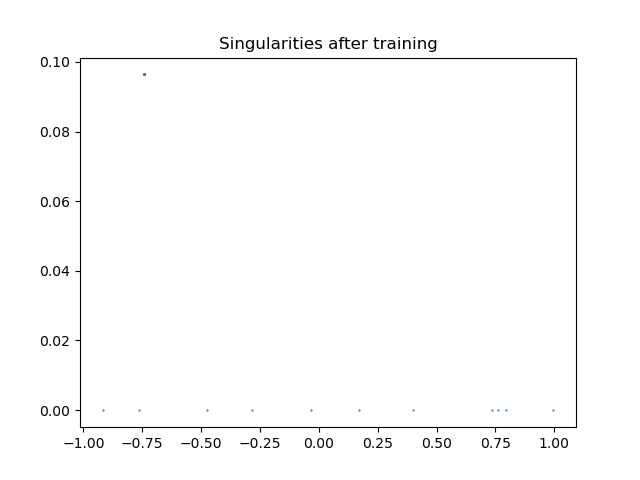

In [21]:
# plot singularities after training
takePoints = torch.argwhere( laplacian_u.isnan())
dontTakePoints = torch.argwhere( laplacian_u.isnan())
fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)
ax3.set_title('Singularities after training')
ax3.scatter(xy_grid[takePoints,0].detach().numpy(),xy_grid[takePoints,1].detach().numpy(),s = 0.3)
plt.show()

seems like the solution funciton is not differentiable on the line $\{ x \in \Omega: ~ -1 < x_1 < 1, ~ x_2=0  \} $
This also seems to be the case for the plots below. Since this is a zeroset, this is the (I think unique) solution to the Dirichlet BP form above.

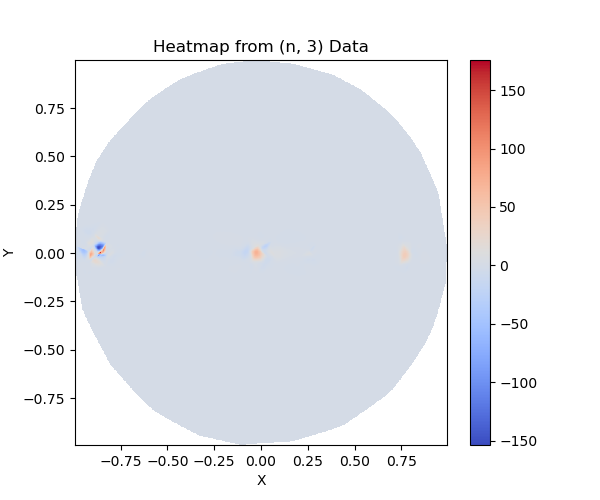

In [22]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = 3000
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = xy_grid[:sampleSizeForDrawing,0].detach().numpy()
data[:,1] = xy_grid[:sampleSizeForDrawing,1].detach().numpy()
data[:,2] = lossOnGrid[:sampleSizeForDrawing].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Heatmap from (n, 3) Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


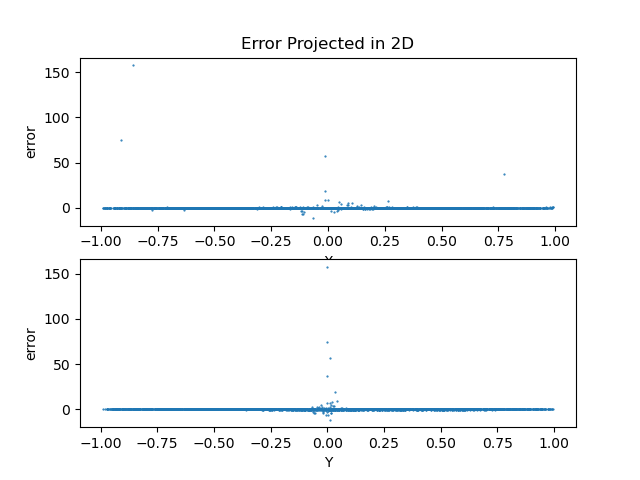

In [23]:
# Plot projected losses on xz and yz planes to see where "problems" happen

maxError = torch.inf
maskSmallerError = data[:,2]<maxError
fig5,ax5 = plt.subplots(2,1)#plt.figure()

ax5[0].set_title('Error Projected in 2D')
ax5[0].set_xlabel('X')
ax5[0].set_ylabel('error')


ax5[1].set_xlabel('Y')
ax5[1].set_ylabel('error')

ax5[0].scatter(data[maskSmallerError,0], data[maskSmallerError,2], s= 0.3)
ax5[1].scatter(data[maskSmallerError,1], data[maskSmallerError,2], s= 0.3)
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_14256\3043282009.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z, cmap='viridis')


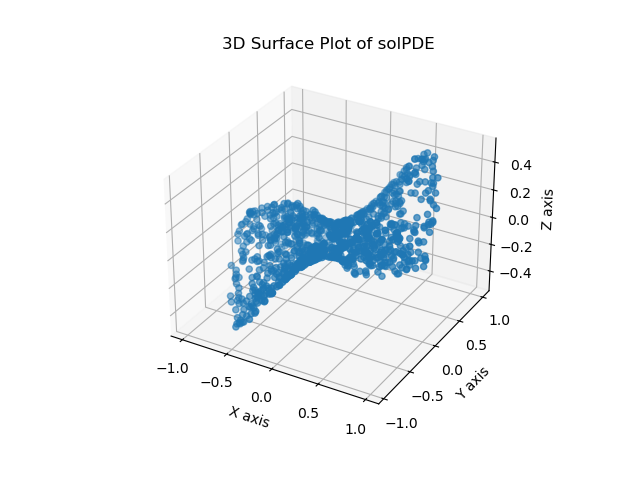

In [24]:

numPointsPlot = 1000
x = xy_grid[:numPointsPlot,0].view(-1).detach().numpy()
y = xy_grid[:numPointsPlot,1].view(-1).detach().numpy()
#X = x.tile((numPointsPlot,1)).detach().numpy()
#Y = y.view(-1,1).tile((1, numPointsPlot)).detach().numpy()
# Create a grid of x and y values
#x = np.linspace(0, 5, 5)
#y = np.linspace(0, 5, 5)
#X, Y = np.meshgrid(x, y)

# Compute Z values using the function f(x, y)
z = solPDE(xy_grid[:numPointsPlot]).view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z, cmap='viridis')

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show()


there seems to be a sharp corner at y = 0